# Homework 2: Digit Recognition

### Load the necessary Libraries

In [1]:
import os
import tarfile
import json
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision
from torchvision.transforms import functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from tqdm import tqdm
import random
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.amp import autocast, GradScaler
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Prepare the Data

In [3]:
# Dataset path
data_root = "/content/drive/MyDrive/NYCU/HW2/nycu-hw2-data"

# Extract the dataset if not already done
if not os.path.exists(data_root):
  print("Extracting")
  dataset_path = "/content/drive/MyDrive/NYCU/HW2/nycu-hw2-data.tar.gz"
  extract_path = "/content/drive/MyDrive/NYCU/HW2"
  os.makedirs(extract_path, exist_ok=True)
  with tarfile.open(dataset_path, "r:gz") as tar:
      tar.extractall(path=extract_path)

In [4]:
# Paths
train_img_dir = os.path.join(data_root, "train")
val_img_dir = os.path.join(data_root, "valid")
test_img_dir = os.path.join(data_root, "test")
train_ann_path = os.path.join(data_root, "train.json")
val_ann_path = os.path.join(data_root, "valid.json")


In [5]:
# Load COCO Annotations
with open(train_ann_path) as f:
    train_anns = json.load(f)

with open(val_ann_path) as f:
    val_anns = json.load(f)

# Build category_id to label mapping
category_id_to_label = {cat["id"]: int(cat["name"]) for cat in train_anns["categories"]}

## Task 1: Bounding Box classification

### Visualise the train images with the given Bounding Boxes

In [6]:
def visualize_bboxes(image_path, annotations, category_mapping, zoom_factor=4):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    height, width = image.shape[:2]
    thickness = max(2, int(min(height, width) / 100))
    font_scale = 0.4  # smaller font
    font_thickness = 1

    for ann in annotations:
        bbox = ann['bbox']
        category_id = ann['category_id']
        label = category_mapping[category_id]

        x_min, y_min, w, h = bbox
        x_max = x_min + w
        y_max = y_min + h

        # Draw bounding box
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)),
                      color=(255, 0, 0), thickness=thickness)

        # Draw red label inside top-left corner of the box
        text = str(label)
        (tw, th), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
        text_x = int(x_min) + 2  # small horizontal padding
        text_y = int(y_min) + th + 2  # just below the top line of the box

        cv2.putText(image, text, (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 0, 0), font_thickness, cv2.LINE_AA)

    # Zoom image for display
    zoomed_image = cv2.resize(image, (width * zoom_factor, height * zoom_factor), interpolation=cv2.INTER_NEAREST)

    plt.figure(figsize=(zoomed_image.shape[1] / 100, zoomed_image.shape[0] / 100))
    plt.imshow(zoomed_image)
    plt.axis('off')
    plt.show()



--- Image: 1436.png (image_id: 1436) ---
  - BBox: [8.0, 11.0, 16.0, 23.0], Category ID: 3, Label: 2
  - BBox: [25.0, 14.0, 14.0, 23.0], Category ID: 7, Label: 6


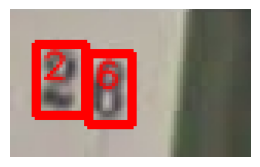


--- Image: 1307.png (image_id: 1307) ---
  - BBox: [38.0, 12.0, 15.0, 39.0], Category ID: 2, Label: 1
  - BBox: [48.0, 5.0, 21.0, 39.0], Category ID: 4, Label: 3


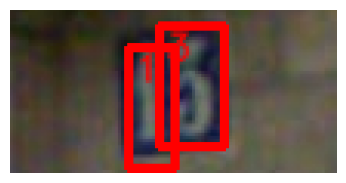


--- Image: 2524.png (image_id: 2524) ---
  - BBox: [75.0, 22.0, 23.0, 44.0], Category ID: 6, Label: 5
  - BBox: [98.0, 19.0, 23.0, 44.0], Category ID: 3, Label: 2
  - BBox: [127.0, 19.0, 20.0, 44.0], Category ID: 10, Label: 9


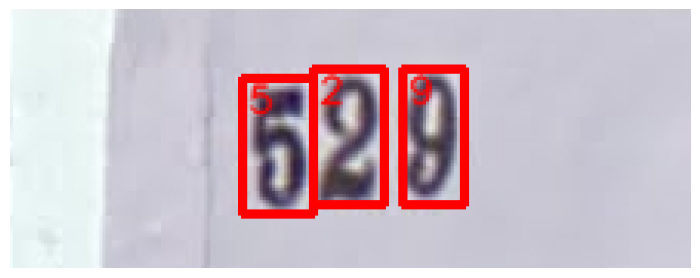

In [17]:
# Sample 3 random images
sample_images = random.sample(val_anns['images'], 3)

for image_info in sample_images:
    img_id = image_info['id']
    img_filename = image_info['file_name']
    img_path = os.path.join(val_img_dir, img_filename)

    # Get annotations
    img_annotations = [ann for ann in val_anns['annotations'] if ann['image_id'] == img_id]

    # Print annotations
    print(f"\n--- Image: {img_filename} (image_id: {img_id}) ---")
    if not img_annotations:
        print("No annotations found.")
    for ann in img_annotations:
        bbox = ann['bbox']
        category_id = ann['category_id']
        label = category_id_to_label[category_id]
        print(f"  - BBox: {bbox}, Category ID: {category_id}, Label: {label}")

    # Show image with bounding boxes
    visualize_bboxes(img_path, img_annotations, category_id_to_label)

### Prepare the dataset

In [ ]:
class DigitDataset(Dataset):
    def __init__(self, ann_data, img_dir, transforms=None):
        """
        Custom dataset for digit detection from COCO-style annotated data.

        Args:
            ann_data (dict): Annotation data loaded from JSON file.
            img_dir (str): Directory containing the image files.
            transforms (callable, optional): Transformation function applied to image and target.
        """
        self.img_dir = img_dir
        self.anns = ann_data["annotations"]
        self.imgs = {img["id"]: img for img in ann_data["images"]}
        self.transforms = transforms

        # Group annotations by image_id for fast lookup during __getitem__
        self.img_id_to_anns = {}
        for ann in self.anns:
            self.img_id_to_anns.setdefault(ann["image_id"], []).append(ann)

        self.img_ids = list(self.img_id_to_anns.keys())

    def __len__(self):
        """Returns the number of unique images in the dataset."""
        return len(self.img_ids)

    def __getitem__(self, idx):
        """
        Loads and returns a single training sample: an image and its corresponding targets.

        Returns:
            img (Tensor): Image tensor.
            target (dict): Dictionary containing bounding boxes, labels, and other metadata.
        """
        image_id = self.img_ids[idx]
        img_info = self.imgs[image_id]
        img_path = os.path.join(self.img_dir, img_info["file_name"])
        img = Image.open(img_path).convert("RGB")  # Ensure RGB format

        # Retrieve all annotations for this image
        anns = self.img_id_to_anns[image_id]
        boxes = []
        labels = []

        for ann in anns:
            bbox = ann["bbox"]  # COCO format: [x_min, y_min, width, height]
            x_min, y_min, w, h = bbox
            boxes.append([x_min, y_min, x_min + w, y_min + h])  # Convert to [x1, y1, x2, y2]
            labels.append(ann["category_id"])  # Should be in the range [0–9]

        # Convert annotations to PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([image_id])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])  # Area of each box
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)  # No crowd annotations

        # Construct the target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        # Apply transformations if specified
        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target


### Define model and parameters

In [9]:
# Load pre-trained Faster R-CNN
model = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

# Replace the classifier with one that has num_classes = 11
# (10 digits + 1 background class)
num_classes = 11
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, num_classes
)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 216MB/s]


In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [11]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005) #changed lr from 0.005
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

### Data Preprocessing

In [12]:
class ResizeWithBoxes:
    def __init__(self, min_size):
        self.min_size = min_size  # Resize shorter side to this

    def __call__(self, image, target):
        orig_w, orig_h = image.size

        # Compute scale
        scale = self.min_size / min(orig_w, orig_h)
        new_w, new_h = int(orig_w * scale), int(orig_h * scale)

        # Resize image
        image = F.resize(image, (new_h, new_w))

        # Resize boxes
        boxes = target["boxes"].clone()
        boxes *= scale
        target["boxes"] = boxes

        return image, target

class ResizeImageOnly: # for test set images
    def __init__(self, min_size):
        self.min_size = min_size

    def __call__(self, image):
        orig_w, orig_h = image.size
        scale = self.min_size / min(orig_w, orig_h)
        new_w, new_h = int(orig_w * scale), int(orig_h * scale)
        image = F.resize(image, (new_h, new_w))
        return image


In [13]:
def get_transform(train=True):
    if train:
        resize = ResizeWithBoxes(512)

        def apply_transform(img, target):
            img, target = resize(img, target)
            img = F.to_tensor(img)
            return img, target

    else:
        resize = ResizeImageOnly(512)

        def apply_transform(img, target=None):
            img = resize(img)
            img = F.to_tensor(img)
            return img, {}

    return apply_transform


In [14]:
# Initialize datasets
train_dataset = DigitDataset(train_anns, train_img_dir, transforms=get_transform())
val_dataset = DigitDataset(val_anns, val_img_dir, transforms=get_transform())

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)), pin_memory=True) #change to 4 workers!!
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)), pin_memory=True) # change to 8 batch size...


In [15]:
class TestDataset(Dataset):
    def __init__(self, image_dir, transforms=None):
        self.image_paths = sorted(os.listdir(image_dir))
        self.image_dir = image_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        file_name = self.image_paths[idx]
        img_path = os.path.join(self.image_dir, file_name)
        img = Image.open(img_path).convert("RGB")
        orig_size = img.size  # (width, height)
        image_id = int(os.path.splitext(file_name)[0])  # Handles "3.png" -> 3

        if self.transforms:
            img, _ = self.transforms(img, {})  # dummy target, will be ignored

        return img, image_id, orig_size

test_dataset = TestDataset(test_img_dir, transforms=get_transform(train=False))
test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

### Training Loop

In [16]:
num_epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = GradScaler()

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

    for images, targets in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.amp.autocast(device_type='cuda'):
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_loss = loss.item()
        total_loss += batch_loss
        avg_loss = total_loss / len(train_loader)
        pbar.set_postfix(loss=batch_loss)

    print(f"[Epoch {epoch+1}] Training Loss: {avg_loss:.4f}")
    print(loss_dict)
    lr_scheduler.step()


[Epoch 1] Training Loss: 1.0652


[Epoch 2] Training Loss: 1.0733


[Epoch 3] Training Loss: 1.0663


[Epoch 4] Training Loss: 1.0919


[Epoch 5] Training Loss: 1.1175


[Epoch 6] Training Loss: 1.1255


[Epoch 7] Training Loss: 1.1253


[Epoch 8] Training Loss: 1.1241


[Epoch 9] Training Loss: 1.1239


[Epoch 10] Training Loss: 1.1282


### Inference

In [19]:
from PIL import Image

img_path = "/content/drive/MyDrive/NYCU/HW2/nycu-hw2-data/train/17919.png"
img = Image.open(img_path)
img.show()  # optional

In [20]:

# Inference & Save pred.json
#model.load_state_dict(torch.load("/content/drive/MyDrive/NYCU/HW2/final.pth"))
model.eval()
results = []

for images, image_ids, orig_sizes in tqdm(test_loader, desc=f"[Epoch {epoch+1}] Generating predictions"):
    images = [img.to(device) for img in images]
    with torch.no_grad():
        outputs = model(images)

    for i, output in enumerate(outputs):
        image_id = image_ids[i]
        orig_w, orig_h = orig_sizes[i]
        scale = 512 / min(orig_w, orig_h)
        scale_x = 1 / scale
        scale_y = 1 / scale

        boxes = output["boxes"].cpu().numpy()
        scores = output["scores"].cpu().numpy()
        labels = output["labels"].cpu().numpy()

        # Vectorized rescaling
        boxes[:, [0, 2]] *= scale_x  # x_min, x_max
        boxes[:, [1, 3]] *= scale_y  # y_min, y_max

        for box, score, label in zip(boxes, scores, labels):
            x_min, y_min, x_max, y_max = box

            '''# Map back to original image size
            x_min *= scale_x
            x_max *= scale_x
            y_min *= scale_y
            y_max *= scale_y'''

            width = x_max - x_min
            height = y_max - y_min

            threshold = 0.5

            if label > 0 and score >= threshold:
              results.append({
                  "image_id": int(image_id),
                  "bbox": [float(x_min), float(y_min), float(width), float(height)],
                  "score": float(score),
                  "category_id": int(label) #TD: +1 or not
                  })

[Epoch 10] Generating predictions: 100%|██████████| 3267/3267 [34:08<00:00,  1.59it/s]


### Save Predictions

In [23]:
# Save prediction file for this epoch
pred_path = "/content/drive/MyDrive/NYCU/HW2/pred.json"
#pred_path = f"pred_epoch{epoch+1}.json"
with open(pred_path, "w") as f:
    json.dump(results, f)

print(f"[Epoch {epoch+1}] Saved predictions to {pred_path}")

[Epoch 10] Saved predictions to /content/drive/MyDrive/NYCU/HW2/pred.json


Visuallizing the results:


--- Image: 3905.png (image_id: 3905) ---
  - BBox: [92.53524017333984, 21.267139434814453, 20.645523071289062, 36.900146484375], Category ID: 1, Label: 0, Score: 0.9327
  - BBox: [108.76705932617188, 18.725784301757812, 17.90019989013672, 38.17475891113281], Category ID: 10, Label: 9, Score: 0.9317
  - BBox: [76.65519714355469, 18.676895141601562, 18.18885040283203, 39.15060043334961], Category ID: 2, Label: 1, Score: 0.9249
  - BBox: [125.27088928222656, 20.174705505371094, 17.069137573242188, 36.1521110534668], Category ID: 8, Label: 7, Score: 0.8744


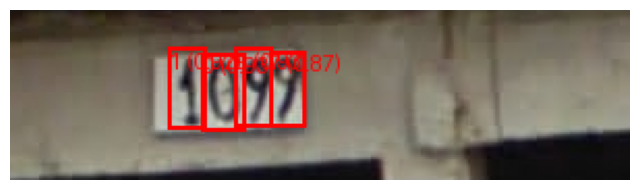


--- Image: 8878.png (image_id: 8878) ---
  - BBox: [56.069091796875, 6.409849166870117, 13.336044311523438, 20.817607879638672], Category ID: 5, Label: 4, Score: 0.9368
  - BBox: [47.653499603271484, 5.368334770202637, 8.845550537109375, 23.09362030029297], Category ID: 2, Label: 1, Score: 0.8252


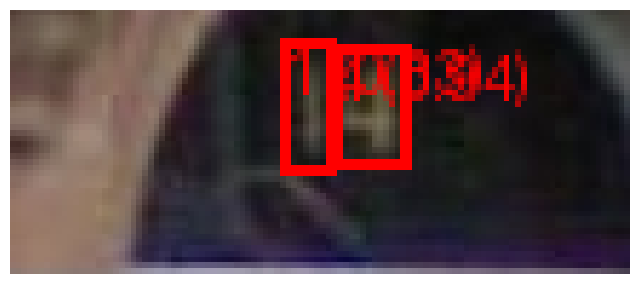


--- Image: 968.png (image_id: 968) ---
  - BBox: [250.99990844726562, 86.74057006835938, 22.230010986328125, 37.19233703613281], Category ID: 1, Label: 0, Score: 0.8863
  - BBox: [236.2200469970703, 85.01239776611328, 18.860992431640625, 36.58647155761719], Category ID: 2, Label: 1, Score: 0.5681


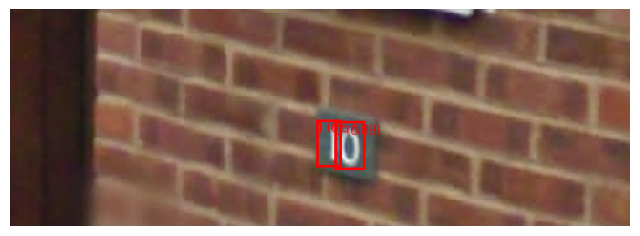

In [21]:
# Paths
pred_path = "/content/drive/MyDrive/NYCU/HW2/pred.json"

#category_id to label mapping
category_id_to_label = {
    1: "0", 2: "1", 3: "2", 4: "3", 5: "4",
    6: "5", 7: "6", 8: "7", 9: "8", 10: "9"
}

# Load predictions
with open(pred_path) as f:
    predictions = json.load(f)

# Organize predictions by image_id
from collections import defaultdict
img_id_to_preds = defaultdict(list)
for pred in predictions:
    img_id_to_preds[pred['image_id']].append(pred)

# Sample a few image_ids with predictions
sample_image_ids = random.sample(list(img_id_to_preds.keys()), 3)

# Visualization function
def visualize_predictions(img_path, preds, id2label):
    image = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    for pred in preds:
        x, y, w, h = pred['bbox']
        label = id2label.get(pred['category_id'], "?")
        score = pred['score']

        draw.rectangle([x, y, x + w, y + h], outline="red", width=2)
        draw.text((x, y), f"{label} ({score:.2f})", fill="red")

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Display samples
for image_id in sample_image_ids:
    file_name = f"{image_id}.png"
    img_path = os.path.join(test_img_dir, file_name)
    preds = img_id_to_preds[image_id]

    print(f"\n--- Image: {file_name} (image_id: {image_id}) ---")
    if not preds:
        print("No predictions.")
    for pred in preds:
        bbox = pred["bbox"]
        category_id = pred["category_id"]
        label = category_id_to_label.get(category_id, "?")
        score = pred["score"]
        print(f"  - BBox: {bbox}, Category ID: {category_id}, Label: {label}, Score: {score:.4f}")

    visualize_predictions(img_path, preds, category_id_to_label)


In [31]:
torch.save(model.state_dict(), "/content/drive/MyDrive/NYCU/HW2/best_model.pth")

generate pred.json

## Task 2: Recognize the entire digit in the image

In [43]:
with open("/content/drive/MyDrive/NYCU/HW2/pred_run1.json", "r") as f:
    predictions = json.load(f)

In [46]:
# Group predictions by image_id
image_predictions = defaultdict(list)

for pred in predictions:
    image_id = pred["image_id"]
    bbox = pred["bbox"]  # Format: [x, y, width, height]
    x_center = bbox[0] + bbox[2] / 2
    digit = int(pred["category_id"]) -1
    score = pred["score"]

    # Optional: filter out low-confidence detections
    #if score > 0.5:
    image_predictions[image_id].append((x_center, digit))


In [47]:
results = []

for image_id, preds in image_predictions.items():
    # Sort digits by x-center to get left-to-right order
    preds.sort(key=lambda x: x[0])

    # Extract the digit values and form the number
    number = ''.join(str(digit) for _, digit in preds)

    # Save result
    results.append({"image_id": image_id, "pred_label": number})

In [48]:
# Save to CSV
df = pd.DataFrame(results)
df.to_csv("/content/drive/MyDrive/NYCU/HW2/pred_run1.csv", index=False)


print("pred.csv successfully saved")

pred.csv successfully saved to
